In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors


In [2]:
def improvedLernplan(weights, starting_date, offDays, offHalfdays, examDates):
    """
    Create an improved learning plan for the given weights and constraints

    :param weights: dictionary with the subjects as keys and the weights as values
    :param starting_date: the starting date of the learning plan
    :param offDays: list of days where no learning should be done
    :param offHalfdays: list of half days where no learning should be done
    :param examDates: dictionary with the subjects as keys and the exam dates as values
    """

    # Calculate the number of days from starting_date to the last exam
    endDate = max(datetime.datetime.strptime(date, '%d.%m.%Y') for date in examDates.values())
    Days = (endDate - datetime.datetime.strptime(starting_date, '%d.%m.%Y')).days

    # Initialize learning plan
    lernPlan = np.zeros((Days + 1, 2), dtype=object)
    days = [(datetime.datetime.strptime(starting_date, '%d.%m.%Y') + datetime.timedelta(days=i)).strftime('%d.%m.%Y') for i in range(Days + 1)]

    # Mark offDays, offHalfdays, and examDays
    for i, current_date in enumerate(days):
        if current_date in offDays:
            lernPlan[i, :] = 'free'
        if current_date in examDates.values():
            subject = [key for key, value in examDates.items() if value == current_date][0]
            lernPlan[i, :] = f'exam {subject}'
        if current_date in offHalfdays:
            lernPlan[i, 1] = 'free'

    # Calculate available half-days for learning
    total_weight = sum(weights.values())
    total_lernhalbtage = np.sum(lernPlan == 0)
    subjects_half_days = {subject: round(weight / total_weight * total_lernhalbtage) for subject, weight in weights.items()}

    # Adjust for rounding errors
    remaining_days = total_lernhalbtage - sum(subjects_half_days.values())
    for _ in range(remaining_days):
        max_subject = max(subjects_half_days, key=subjects_half_days.get)
        subjects_half_days[max_subject] += 1

    # Sort subjects by exam date
    sorted_subjects = sorted(examDates, key=lambda x: datetime.datetime.strptime(examDates[x], '%d.%m.%Y'))

    # Allocate learning times for each subject
    for subject in sorted_subjects:
        rowidx_exam = days.index(examDates[subject])
        lernPlan_exam = lernPlan[:rowidx_exam, :]
        available_slots = np.argwhere(lernPlan_exam == 0)

        if len(available_slots) >= subjects_half_days[subject]:
            selected_slots = np.linspace(0, len(available_slots) - 1, subjects_half_days[subject], dtype=int)
            for idx in selected_slots:
                slot = available_slots[idx]
                lernPlan[slot[0], slot[1]] = subject

    # Visualize the learning plan with weekdays
    fig, ax = plt.subplots()
    ax.set_axis_off()
    cmap = plt.cm.tab20
    unique_subjects = list(weights.keys()) + ['free'] + [f'exam {subj}' for subj in weights.keys()]
    color_map = {subj: cmap(i / len(unique_subjects)) for i, subj in enumerate(unique_subjects)}
    color_map['free'] = (0.5, 1, 0.5)  # Set 'free' to green

    cell_colors = []
    for row in lernPlan:
        cell_colors.append([color_map.get(cell, (1, 1, 1)) for cell in row])

    col_labels = ['Datum', 'Wochentag', 'Vormittag', 'Nachmittag']
    cell_text = [[f"{days[i]}", (datetime.datetime.strptime(days[i], '%d.%m.%Y')).strftime('%A')] + list(lernPlan[i]) for i in range(len(days))]
    cell_colors = [[(1, 1, 1), (1, 1, 1)] + cell_colors[i] for i in range(len(cell_colors))]

    ax.table(cellText=cell_text, cellColours=cell_colors, colLabels=col_labels, loc='center')
    plt.show()

    # Save to .ics file
    
    # Determine if the plan is for winter or summer
    start_month = datetime.datetime.strptime(starting_date, '%d.%m.%Y').month
    current_year = datetime.datetime.strptime(starting_date, '%d.%m.%Y').year
    if start_month in [10, 11, 12, 1, 2, 3]:  # Winter months
        filename = f'LernplanHS{str(current_year)[-2:]}'
    else:  # Summer months
        filename = f'LernplanFS{str(current_year)[-2:]}'

    with open(filename + '.ics', 'w') as f:
        f.write('BEGIN:VCALENDAR\nVERSION:2.0\nPRODID:-//hacksw/handcal//NONSGML v1.0//EN\n')
        for i, current_date in enumerate(days):
            for j, session in enumerate(['Vormittag', 'Nachmittag']):
                if lernPlan[i, j] not in ['free', None] and not lernPlan[i, j].startswith('exam'):
                    # Umwandlung des Datums in das Format yyyymmdd
                    formatted_date = datetime.datetime.strptime(current_date, '%d.%m.%Y').strftime('%Y%m%d')
                    start_time = '080000' if session == 'Vormittag' else '130000'
                    end_time = '120000' if session == 'Vormittag' else '170000'
                    
                    f.write(f'BEGIN:VEVENT\n')
                    f.write(f'DTSTART;TZID=Europe/Berlin:{formatted_date}T{start_time}\n')
                    f.write(f'DTEND;TZID=Europe/Berlin:{formatted_date}T{end_time}\n')
                    f.write(f'SUMMARY:{lernPlan[i, j]} lernen\n')
                    f.write(f'END:VEVENT\n')
        f.write('END:VCALENDAR\n')


    print('Calendar file created: ' + filename + '.ics')
    
    total_learning_days = np.sum(lernPlan != 'free') / 2
    subject_learning_days = {subject: np.sum(lernPlan == subject) / 2 for subject in weights.keys()}

    print(f"Total learning half-days: {int(total_learning_days*2)}")
    for subject, days in subject_learning_days.items():
        print(f"Learning half-days for {subject}: {int(days*2)}")
    

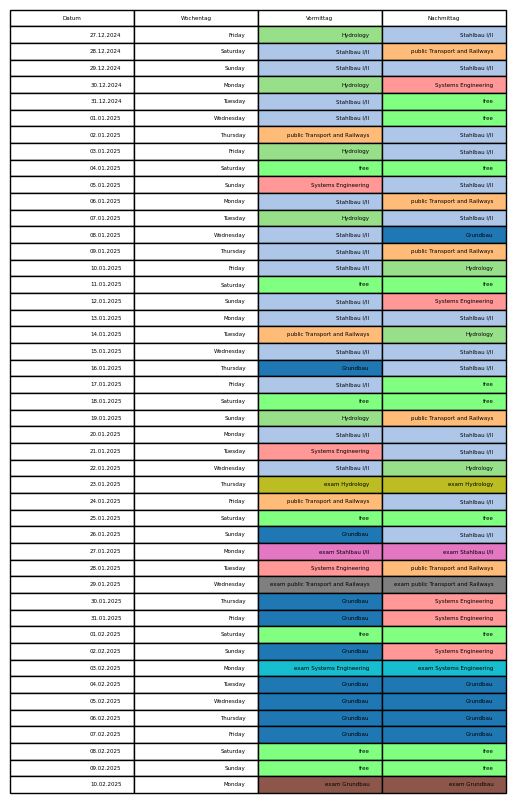

Calendar file created: LernplanHS24.ics
Total learning half-days: 75
Learning half-days for Grundbau: 14
Learning half-days for Stahlbau I/II: 27
Learning half-days for public Transport and Railways: 8
Learning half-days for Hydrology: 8
Learning half-days for Systems Engineering: 8


In [3]:
weights = { "Grundbau": 5, "Stahlbau I/II": 9, "public Transport and Railways": 3, "Hydrology": 3, "Systems Engineering":3 }
starting_date = "27.12.2024"
offDays = ["04.01.2025", "11.01.2025", "18.01.2025", "01.02.2025", "25.01.2025", "08.02.2025", "09.02.2025"]
offHalfdays = ["31.12.2024", "01.01.2025", "17.01.2025"]
examDates = { "Grundbau": "10.02.2025", "Stahlbau I/II": "27.01.2025", "public Transport and Railways": "29.01.2025", "Hydrology": "23.01.2025", "Systems Engineering":"03.02.2025" }

improvedLernplan(weights, starting_date, offDays, offHalfdays, examDates)